In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [6]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        L = torch.abs(self.data_rho)
        if size_average:
            self._rho_loss = L.mean()
        else:
            self._rho_loss = L.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [7]:
models = {'16': Net(16).to(device), '32': Net(32).to(device), '64': Net(64).to(device)}
# models = {'64': Net(64).to(device)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [8]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data.to(device))
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data.to(device)) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [9]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
data_rho_lambda = lambda q: 'data_rho: {}'.format(q)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
line_extra = lambda i, l, p, q: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p) + '\n' + data_rho_lambda(q)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data.to(device)) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data.to(device), reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k], models[k].data_rho))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [ ]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

### Loss графики
1. Loss
2. Rho Loss

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7f28154b8b00>])

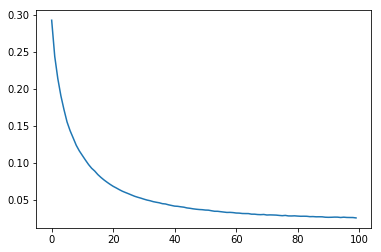

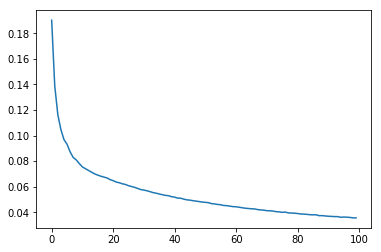

In [11]:
test_log['64']
losses = np.array([[it[0],it[1]] for it in test_log['64']])
N = losses.shape[0]
plt.figure(1), plt.plot(range(N), losses[:,0])
plt.figure(2), plt.plot(range(N), losses[:,1])

In [21]:
mod = '64'
mod_ = int(mod)
data, _ = next(iter(test_loader))
output = models[mod](data.to(device))
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
decoded = models[mod].decode(torch.eye(mod_).to(device))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
decoded_neg = models[mod].decode(-torch.eye(mod_).to(device))
dec_neg_to_plot = ((decoded_neg.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
with torch.no_grad():
    encoded = models[mod].E(data.view(-1, 28*28).to(device))
    print((torch.abs(encoded) > 0.05).sum(1))
    encoded[torch.abs(encoded) < 0.05] = 0.
    decoded_f = models[mod].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

tensor([11, 20,  8, 19, 13,  9, 16, 23, 25, 14, 14, 19,  7, 11,  6, 21, 11, 13,
        25,  8, 10, 12, 20, 15,  8, 21, 10, 10, 17,  8, 21,  6, 13, 18,  9, 18,
        19,  6, 15,  3,  4, 12, 15, 18, 18,  8, 13, 19, 14, 15],
       device='cuda:0')


### Размер латентного слоя: 64
1. Средний уровень активации каждого нейрона латентного слоя
2. Распределение уровней активации всех нейоронов латентного слоя

/media/alex/Data/alex/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


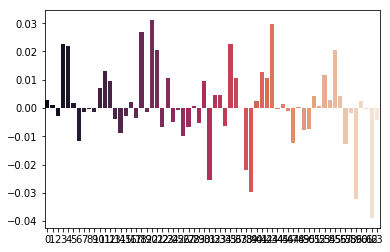

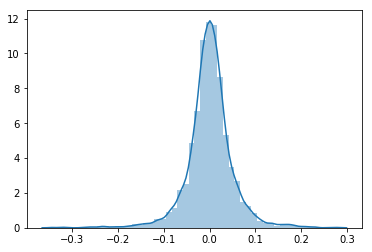

In [22]:
mod = '64'
mod_ = int(mod)
data, _ = next(iter(test_loader))
with torch.no_grad():
    encoded = models[mod].E(data.view(-1, 28*28).to(device))
#     print(encoded.size())
    plt.figure(1), sns.barplot(np.arange(mod_), encoded.mean(0), palette="rocket")
    plt.figure(2), sns.distplot(encoded.reshape([-1,1]).cpu().numpy())
#     plt.figure(3), sns.violinplot(encoded.reshape([-1,1]).cpu().numpy())

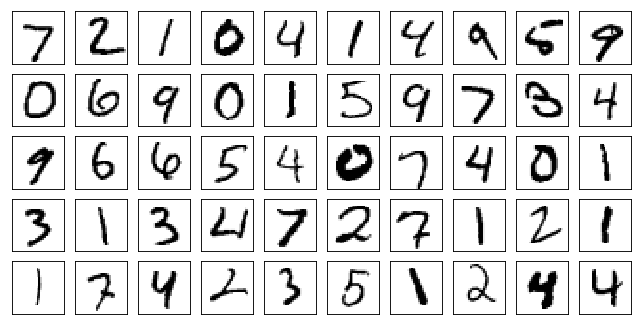

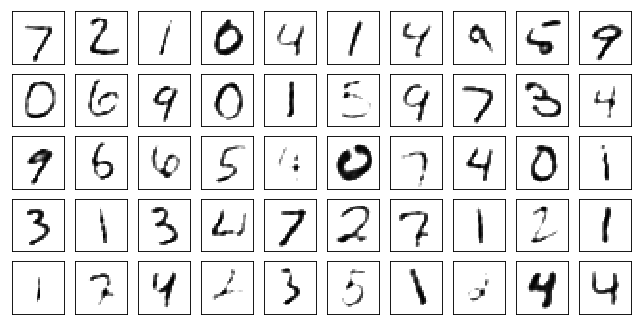

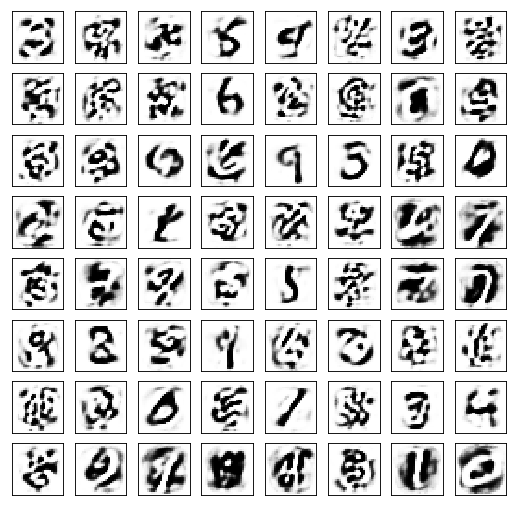

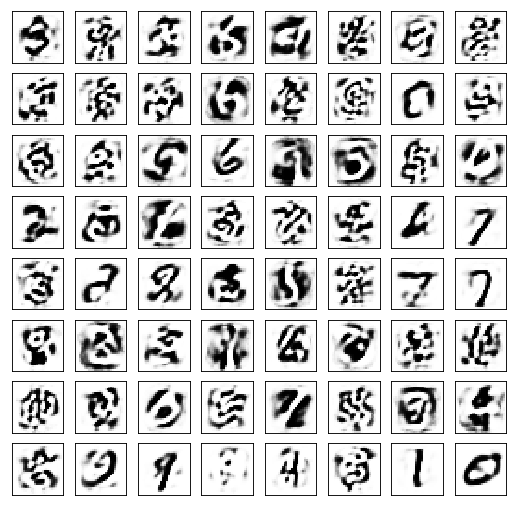

In [23]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
# plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))
plot_mnist(dec_neg_to_plot, (8, 8))

In [24]:
mod = '32'
mod_ = int(mod)
data, _ = next(iter(test_loader))
output = models[mod](data.to(device))
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
decoded = models[mod].decode(torch.eye(mod_).to(device))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
decoded_neg = models[mod].decode(-torch.eye(mod_).to(device))
dec_neg_to_plot = ((decoded_neg.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
with torch.no_grad():
    encoded = models[mod].E(data.view(-1, 28*28).to(device))
    print((torch.abs(encoded) > 0.05).sum(1))
    encoded[torch.abs(encoded) < 0.05] = 0.
    decoded_f = models[mod].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

tensor([ 6, 12,  4, 11,  7,  5,  8, 13, 15, 11,  9, 10,  4, 10,  3,  9,  9, 13,
        14,  6,  7,  5, 11,  9,  4, 14,  5, 12,  9,  5, 10,  5, 13, 14,  7,  9,
        12,  3, 12,  2,  3,  6, 10, 10, 13,  5,  9,  8, 12,  9],
       device='cuda:0')


### Размер латентного слоя: 32
1. Средний уровень активации каждого нейрона латентного слоя
2. Распределение уровней активации всех нейоронов латентного слоя

/media/alex/Data/alex/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


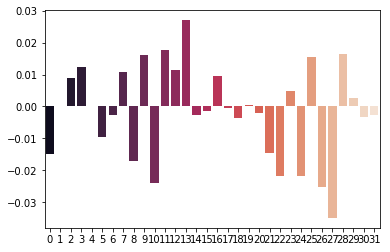

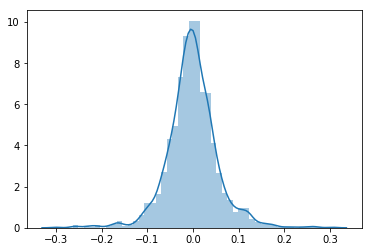

In [25]:
mod = '32'
mod_ = int(mod)
data, _ = next(iter(test_loader))
with torch.no_grad():
    encoded = models[mod].E(data.view(-1, 28*28).to(device))
#     print(encoded.size())
    plt.figure(1), sns.barplot(np.arange(mod_), encoded.mean(0), palette="rocket")
    plt.figure(2), sns.distplot(encoded.reshape([-1,1]).cpu().numpy())
#     plt.figure(3), sns.violinplot(encoded.reshape([-1,1]).cpu().numpy())

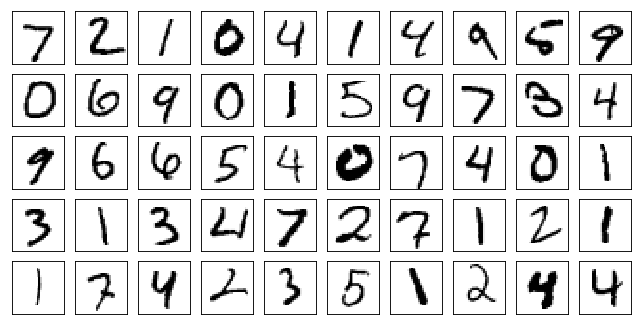

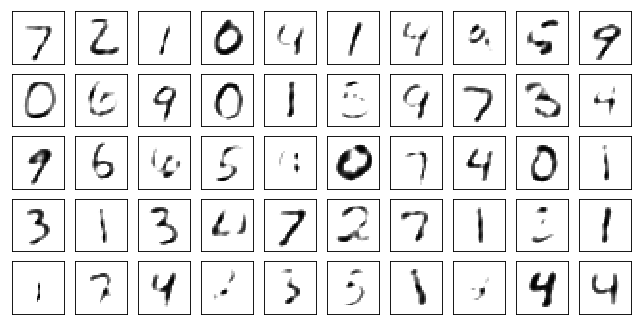

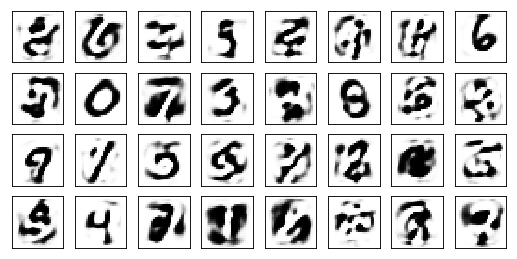

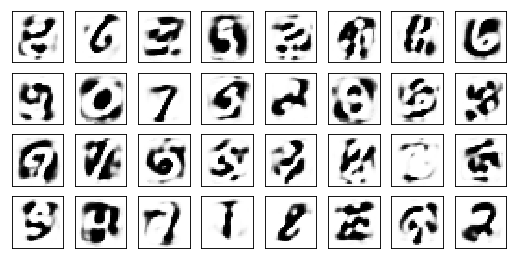

In [26]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
# plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))
plot_mnist(dec_neg_to_plot, (8, 8))

In [27]:
mod = '16'
mod_ = int(mod)
data, _ = next(iter(test_loader))
output = models[mod](data.to(device))
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
decoded = models[mod].decode(torch.eye(mod_).to(device))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
decoded_neg = models[mod].decode(-torch.eye(mod_).to(device))
dec_neg_to_plot = ((decoded_neg.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
with torch.no_grad():
    encoded = models[mod].E(data.view(-1, 28*28).to(device))
    print((torch.abs(encoded) > 0.05).sum(1))
    encoded[torch.abs(encoded) < 0.05] = 0.
    decoded_f = models[mod].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

tensor([4, 7, 3, 7, 2, 2, 6, 3, 7, 4, 8, 7, 4, 4, 3, 5, 3, 6, 8, 4, 6, 4, 4, 4,
        3, 8, 4, 4, 5, 3, 6, 2, 8, 9, 5, 6, 5, 5, 3, 3, 2, 1, 4, 2, 5, 5, 4, 5,
        6, 3], device='cuda:0')


### Размер латентного слоя: 16
1. Средний уровень активации каждого нейрона латентного слоя
2. Распределение уровней активации всех нейоронов латентного слоя

/media/alex/Data/alex/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


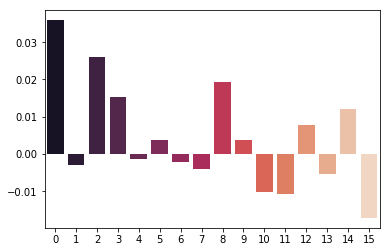

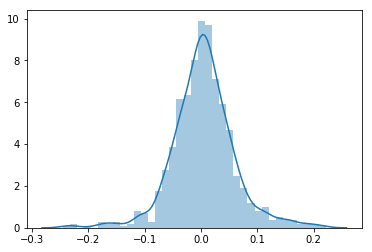

In [28]:
mod = '16'
mod_ = int(mod)
data, _ = next(iter(test_loader))
with torch.no_grad():
    encoded = models[mod].E(data.view(-1, 28*28).to(device))
#     print(encoded.size())
    plt.figure(1), sns.barplot(np.arange(mod_), encoded.mean(0), palette="rocket")
    plt.figure(2), sns.distplot(encoded.reshape([-1,1]).cpu().numpy())
#     plt.figure(3), sns.violinplot(encoded.reshape([-1,1]).cpu().numpy())

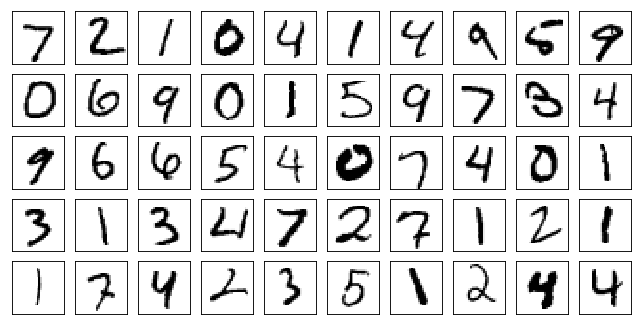

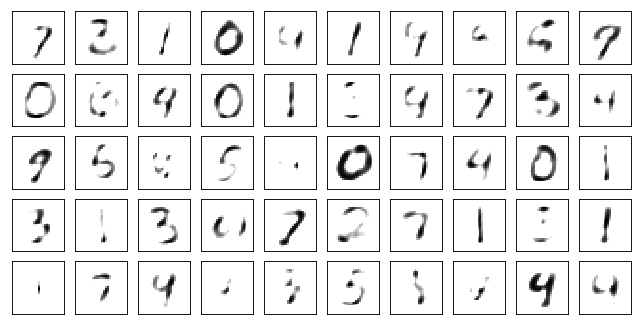

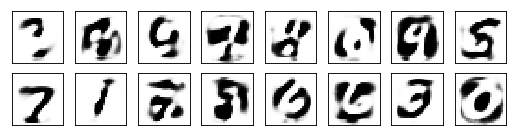

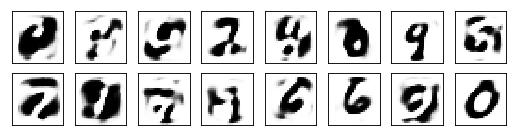

In [29]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
# plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))
plot_mnist(dec_neg_to_plot, (8, 8))